

```
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark
```

In [ ]:
import os
os.environ["SPARK_HOME"] = "spark-2.4.7-bin-hadoop2.7"
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext(appName="sentiML", master="local[2]")
sqlContext = SQLContext(sc)

In [ ]:
df = sqlContext.read.format('csv').options(header='false').load('training.csv')
df.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [ ]:
df.count()

1600000

In [ ]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import rand 

df = df.drop('_c1','_c2','_c3','_c4')
df = df.orderBy(rand())
df = df.rdd.map(lambda x: (0, x[1]) if(x[0]=='0')else(1,x[1])).toDF()
df = df.selectExpr("_1 as label", "_2 as tweet")
df.show(5)

+-----+--------------------+
|label|               tweet|
+-----+--------------------+
|    0|sore sore throat....|
|    1|@rebecca_666 Hey ...|
|    0|          It's over |
|    1|@veganhope In tha...|
|    1|had a nice time w...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
(train, test) = df.randomSplit([0.9, 0.1])

In [ ]:
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#converts the input string to lowercase and then splits it by white spaces. 
tok = Tokenizer(inputCol="tweet", outputCol="tokens")
#converts to vector of token counts
cv = CountVectorizer(inputCol="tokens", outputCol='counts')
#Inverse document frequency
idf = IDF(inputCol='counts', outputCol="features", minDocFreq=10)
#predict a binary outcome by using binomial logistic regression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
#set the whole pipeline
pipe = Pipeline(stages=[tok, cv, idf, lr])

pipeFit = pipe.fit(train)
test1pred = pipeFit.transform(test)
test1accuracy = test1pred.filter(test1pred.label == test1pred.prediction).count() / float(test.count())

print("Accuracy: {}".format(test1accuracy))

Accuracy: 0.796793622341859


In [ ]:
test1pred.show(5)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|               tweet|              tokens|              counts|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    0|     &lt;--------...|[, , , , , &lt;--...|(262144,[1,5,18,1...|(262144,[1,5,18,1...|[3.26653671515754...|[0.96326281093694...|       0.0|
|    0| Plans for the Gr...|[, plans, for, th...|(262144,[1,3,9,15...|(262144,[1,3,9,15...|[0.47641335233502...|[0.61690058323199...|       0.0|
|    0| my whole body is...|[, my, whole, bod...|(262144,[1,3,4,5,...|(262144,[1,3,4,5,...|[5.37403188194833...|[0.99538598365025...|       0.0|
|    0|#FacialHairFriday...|[#facialhairfrida...|(262144,[0,14,15,...|(262144,[0,14,15,...|[3.77783983618352...|[0.97763938748161.

[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative')]

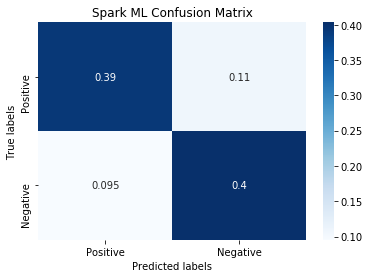

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

labArray =  np.array(test1pred.select("label", "prediction").collect())
  
cm = confusion_matrix(labArray[:,0], labArray[:,1])/len(labArray)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Spark ML Confusion Matrix') 
ax.xaxis.set_ticklabels(['Positive', 'Negative'])
ax.yaxis.set_ticklabels(['Positive', 'Negative'])

In [ ]:
import re

def clean(x):
  text = x[1]
  text = re.sub('@[^\s]+','username', text)
  text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower())
  text = text.split(' ')
  for t in text:
    if x[0] == 1:
      yield(t,1)
    else:
      yield(t,-1)

wordvalue = train.rdd.map(list).flatMap(lambda x : clean(x)).reduceByKey(lambda x,y:x+y).cache()
wordvalue.count()

265349

In [ ]:
wdict = wordvalue.collectAsMap()

In [ ]:
def sents(x):
  label = x[0]
  text = x[1]
  text = re.sub('@[^\s]+','username', text)
  text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower())
  text = text.split(' ')
  a = 0
  for t in text:
    if t in wdict:
      a = a+(wdict.get(t))
  if a > 0:
    return (x[0],1)
  else:
    return (x[0],0)


mytest = test.rdd.map(list).map(lambda x : sents(x)).cache()
mytestaccuracy = mytest.filter(lambda x:x[0] == x[1]).count() / float(mytest.count())
print("Accuracy using Dictionary: {}".format(mytestaccuracy))

Accuracy using Dictionary: 0.6333410630683706


[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative')]

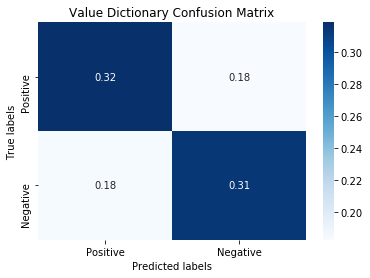

In [ ]:
labArray =  np.array(mytest.collect())
  
cm = confusion_matrix(labArray[:,0], labArray[:,1])/len(labArray)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Value Dictionary Confusion Matrix') 
ax.xaxis.set_ticklabels(['Positive', 'Negative'])
ax.yaxis.set_ticklabels(['Positive', 'Negative'])

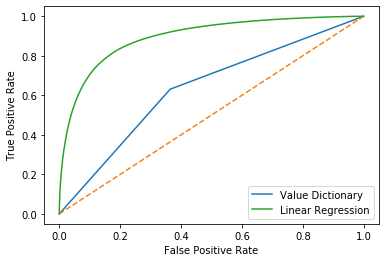

In [ ]:
from sklearn.metrics import roc_curve

fpr_d, tpr_d, thresholds_d = roc_curve(labArray[:,0], labArray[:,1])

plt.plot(fpr_d, tpr_d, label='Value Dictionary')

plt.plot([0, 1], [0, 1], '--')
plt.plot(pipeFit.stages[-1].summary.roc.select('FPR').collect(),
         pipeFit.stages[-1].summary.roc.select('TPR').collect(), label='Linear Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show() 

In [ ]:
from pyspark.streaming import StreamingContext

def initStreamingContext():
    try:
      ssc.end()
    except:
      pass
    finally:
      # Creating Streaming Context with batch window size of 1 second
      ssc = StreamingContext(sc, 10)
      return ssc

In [ ]:
import socket
import time

ssc = initStreamingContext()
socket_stream = ssc.socketTextStream(socket.gethostname(),2222)
#makes rdd from previous x secs
lines = socket_stream.window(10)

In [ ]:
import re
from pyspark.sql import Row

def sen(x):
  text = x
  text = re.sub('@[^\s]+','username', text)
  text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower())
  text = text.split(' ')
  a = 0
  for t in text:
    if t in wdict:
      a = a+(wdict.get(t))
  if a > 0:
    return (1)
  else:
    return (0)

def myfun(rdd):
    num = float(rdd.count())
    happyness = rdd.filter(lambda x:x == 1).count()/num
    print("Covid Tweets: {:0.2f}, Happyness: {:0.2f}".format(num,happyness))

def myfun2(rdd):
    row = Row("tweet")
    x = rdd.map(row).toDF()
    num = float(x.count())
    a = pipeFit.transform(x)
    happyness = a.filter(a.prediction == 1).count() / num
    print("Covid Tweets: {:0.2f}, Happyness: {:0.2f}".format(num,happyness))

### to use Value Dictionary ###
#lin = lines.map(lambda x : sen(x))
#lin.foreachRDD(myfun)

In [ ]:
lines.foreachRDD(myfun2)

ssc.start()
time.sleep(60)
ssc.stop()

Covid Tweets: 125.00, Happyness: 0.58
Covid Tweets: 65.00, Happyness: 0.66
Covid Tweets: 124.00, Happyness: 0.57
Covid Tweets: 99.00, Happyness: 0.61
Covid Tweets: 70.00, Happyness: 0.59
